# Assignment 1

### Settings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from dataclasses import dataclass, field

DATA_DIR = "."  # change if needed

BLADE_FILE = os.path.join(DATA_DIR, "bladedat.txt")

AIRFOIL_FILES = {
    1.000: os.path.join(DATA_DIR, "cylinder_ds.txt"),
    0.241: os.path.join(DATA_DIR, "FFA-W3-241_ds.txt"),
    0.301: os.path.join(DATA_DIR, "FFA-W3-301_ds.txt"),
    0.360: os.path.join(DATA_DIR, "FFA-W3-360_ds.txt"),
    0.480: os.path.join(DATA_DIR, "FFA-W3-480_ds.txt"),
    0.600: os.path.join(DATA_DIR, "FFA-W3-600_ds.txt"),
}

# Assignment 1 Case 1
rho = 1.225
B = 3
omega0 = 0.72      # rad/s
V0_hub0 = 8.0      # m/s
theta_pitch_deg0 = 0.0
dt = 0.15
T_end = 40.0

# Discretization
Nsec = 40


### Config / Operating point / State / Recorder
- A1-A3

In [57]:
# To turn on/off models
@dataclass
class ModelConfig: 
    rho: float = 1.225
    B: int = 3
    dt: float = 0.15

    # toggles
    use_prandtl: bool = True
    min_F: float = 0.05

    use_glauert: bool = True

    # numerics
    relax: float = 0.35
    max_iter: int = 80
    tol: float = 1e-4

    # wind settings
    wind_model: str = "constant"
    H: float = 119.0
    shear_exp: float = 0.2

# Varying parameters for A1/A2/A3
@dataclass
class OperatingPoint: 
    V0_hub: float = 8.0
    omega: float = 0.72
    theta_pitch_deg: float = 0.0

    @property
    def theta_pitch(self) -> float:
        return float(np.deg2rad(self.theta_pitch_deg))

# Memory for induction
@dataclass
class InflowState:
    Wz: np.ndarray  # induced axial (normal) velocity per section
    Wy: np.ndarray  # induced tangential velocity per section

# One common state that all modules read/update
@dataclass
class SimulationState:
    t: float
    op: OperatingPoint
    inflow: InflowState

    # outputs at current step
    thrust: float = 0.0
    power: float = 0.0
    pn: np.ndarray = field(default_factory=lambda: np.array([]))
    pt: np.ndarray = field(default_factory=lambda: np.array([]))

    # wind field (per section) for Case 2
    Vz_local: np.ndarray = field(default_factory=lambda: np.array([]))

# Records time-series without solver "knowing" about plotting
@dataclass
class Recorder:
    t: list = field(default_factory=list)
    thrust: list = field(default_factory=list)
    power: list = field(default_factory=list)

    def record(self, state: SimulationState):
        self.t.append(state.t)
        self.thrust.append(state.thrust)
        self.power.append(state.power)



### Read blade geometry

In [58]:
def read_bladedat(path: str):
    data = np.loadtxt(path)
    if data.shape[1] < 4:
        raise ValueError("bladedat.txt must have >= 4 columns: r, beta[deg], c[m], t/c[% or ratio]")

    r = data[:, 0].astype(float)
    beta_deg = data[:, 1].astype(float)
    c = data[:, 2].astype(float)
    tc = data[:, 3].astype(float)

    # convert tc percent -> ratio if needed
    if np.nanmax(tc) > 1.5:
        tc = tc / 100.0

    # sort by radius
    idx = np.argsort(r)
    r = r[idx]
    beta = np.deg2rad(beta_deg[idx])
    c = c[idx]
    tc = tc[idx]
    return r, c, beta, tc

def build_sections(r_tab, c_tab, beta_tab, tc_tab, Nsec: int):
    R = float(np.max(r_tab))

    # IMPORTANT: avoid placing last section exactly at tip
    r_sec = np.linspace(float(np.min(r_tab)), 0.98 * R, Nsec)
    c_sec = np.interp(r_sec, r_tab, c_tab)
    beta_sec = np.interp(r_sec, r_tab, beta_tab)
    tc_sec = np.interp(r_sec, r_tab, tc_tab)

    # element widths
    dr_sec = np.gradient(r_sec)
    return R, r_sec, c_sec, beta_sec, tc_sec, dr_sec

### Init_state()

In [59]:
def init_state(op: OperatingPoint, r_sec):
    """
    Create initial SimulationState for the simulation.
    """
    N = len(r_sec)

    inflow = InflowState(
        Wz=np.zeros(N),
        Wy=np.zeros(N)
    )

    return SimulationState(
        t=0.0,
        op=op,
        inflow=inflow,
        Vz_local=np.zeros(N),   # local wind per section
        pn=np.zeros(N),         # optional: allocate from start
        pt=np.zeros(N)          # optional: allocate from start
    )



### Read airfoil polars + Cl/Cd(alpha, tc) interpolation

In [60]:
def read_airfoil_file(path: str):
    data = np.loadtxt(path)
    if data.shape[1] < 3:
        raise ValueError(f"{path} must have >= 3 columns: alpha[deg], Cl, Cd (extra columns allowed)")

    alpha_deg = data[:, 0].astype(float)
    Cl = data[:, 1].astype(float)
    Cd = data[:, 2].astype(float)

    idx = np.argsort(alpha_deg)
    alpha_deg = alpha_deg[idx]
    Cl = Cl[idx]
    Cd = Cd[idx]
    return alpha_deg, Cl, Cd

def build_polars(airfoil_files: dict):
    polars = {}
    for tc, fname in airfoil_files.items():
        if not os.path.exists(fname):
            raise FileNotFoundError(f"Missing airfoil file: {fname}")
        polars[float(tc)] = read_airfoil_file(fname)
    return polars

POLARS = build_polars(AIRFOIL_FILES)
TC_LEVELS = np.array(sorted(POLARS.keys()), dtype=float)

def cl_cd(alpha_rad: float, tc: float):
    """
    Double interpolation:
      - in alpha inside each polar
      - between thickness levels for tc
    """
    alpha_deg = float(np.rad2deg(alpha_rad))

    tc_clamped = float(np.clip(tc, TC_LEVELS.min(), TC_LEVELS.max()))

    # find bracketing thickness levels
    hi = int(np.searchsorted(TC_LEVELS, tc_clamped, side="right"))
    if hi == 0:
        t0 = t1 = TC_LEVELS[0]
    elif hi >= len(TC_LEVELS):
        t0 = t1 = TC_LEVELS[-1]
    else:
        t0 = TC_LEVELS[hi - 1]
        t1 = TC_LEVELS[hi]

    def interp_alpha(t_level):
        a_deg, Cl_arr, Cd_arr = POLARS[float(t_level)]
        a = float(np.clip(alpha_deg, a_deg.min(), a_deg.max()))
        Cl_i = float(np.interp(a, a_deg, Cl_arr))
        Cd_i = float(np.interp(a, a_deg, Cd_arr))
        return Cl_i, Cd_i

    Cl0, Cd0 = interp_alpha(t0)
    Cl1, Cd1 = interp_alpha(t1)

    if t0 == t1:
        return Cl0, Cd0

    w = (tc_clamped - t0) / (t1 - t0)
    Cl = (1.0 - w) * Cl0 + w * Cl1
    Cd = (1.0 - w) * Cd0 + w * Cd1
    return float(Cl), float(Cd)

### BEM corrections
- A1-A3

In [61]:
def prandtl_F(B: int, r: float, R: float, phi: float):
    """
    Prandtl tip loss factor.
    """
    sphi = np.sin(abs(phi))
    sphi = max(sphi, 1e-6)
    f = (B / 2.0) * (R - r) / (r * sphi)
    # exp(-f) can underflow to 0 which is OK
    F = (2.0 / np.pi) * np.arccos(np.exp(-f))
    return float(np.clip(F, 1e-3, 1.0))

def glauert_fg_from_a(a: float):
    """
    Glauert correction factor fg(a) used in denominator term.
    Lecture form:
      fg = 1 for a <= 1/3
      fg = 0.25*(5 - 3a) for a > 1/3
    """
    if a <= 1.0/3.0:
        return 1.0
    return 0.25 * (5.0 - 3.0 * a)

### Quasi-steady induction solve per section
- A1 aero solver

In [62]:
def solve_induction_for_section(cfg: ModelConfig,
                                Vz0: float, omega: float,
                                r: float, c: float, beta: float, tc: float,
                                theta_pitch: float,
                                Wz_init: float = 0.0, Wy_init: float = 0.0):
    """
    Iteratively solve induced velocities Wz, Wy for one radial section.
    Returns: Wz, Wy, pn, pt
    """
    Wz = float(Wz_init)
    Wy = float(Wy_init)

    for _ in range(cfg.max_iter):
        # Relative wind components
        Vax = Vz0 + Wz
        Vtan = omega * r - Wy

        Vrel = float(np.hypot(Vax, Vtan))
        Vrel = max(Vrel, 1e-6)

        phi = float(np.arctan2(Vax, Vtan))              # inflow angle
        alpha = float(phi - (beta + theta_pitch))       # AoA

        Cl, Cd = cl_cd(alpha, tc)

        # Lift/drag per unit span
        l = 0.5 * cfg.rho * Vrel**2 * c * Cl
        d = 0.5 * cfg.rho * Vrel**2 * c * Cd

        # Loads per unit span (normal/tangential to rotor plane)
        pn = l * np.cos(phi) + d * np.sin(phi)
        pt = l * np.sin(phi) - d * np.cos(phi)

        # Tip loss
        if cfg.use_prandtl:
            F = prandtl_F(cfg.B, r, R_global, phi)
            F = max(F, cfg.min_F)
        else:
            F = 1.0

        # Axial induction a = -Wz / V0 (minus sign because Wz is negative for wake)
        a = -Wz / max(Vz0, 1e-6)

        if cfg.use_glauert:
            fg = glauert_fg_from_a(a)
        else:
            fg = 1.0

        # Denominator term (stability: avoid near-zero)
        Vterm = abs(Vz0 + fg * Wz)
        Vterm = max(Vterm, 1.0)

        # Quasi-steady induced velocities (lecture form)
        Wz_qs = -(cfg.B * l * np.cos(phi)) / (4.0 * np.pi * cfg.rho * r * F * Vterm)
        Wy_qs = -(cfg.B * l * np.sin(phi)) / (4.0 * np.pi * cfg.rho * r * F * Vterm)

        # Relaxation
        Wz_new = (1.0 - cfg.relax) * Wz + cfg.relax * Wz_qs
        Wy_new = (1.0 - cfg.relax) * Wy + cfg.relax * Wy_qs

        if (abs(Wz_new - Wz) < cfg.tol) and (abs(Wy_new - Wy) < cfg.tol):
            Wz, Wy = Wz_new, Wy_new
            break

        Wz, Wy = Wz_new, Wy_new

    return float(Wz), float(Wy), float(pn), float(pt)

### Wind_step()
- A1, Case 2

In [63]:
def wind_step(cfg: ModelConfig, state: SimulationState, r_sec, theta=0.0):
    Vhub = state.op.V0_hub

    if cfg.wind_model == "constant":
        state.Vz_local[:] = Vhub
        return

    if cfg.wind_model == "shear":
        for j in range(len(r_sec)):
            r = r_sec[j]
            z = cfg.H + r * np.cos(theta)  # height of section in rotor disk
            z = max(z, 1e-3)               # avoid negative/zero
            state.Vz_local[j] = Vhub * (z / cfg.H) ** cfg.shear_exp
        return

    raise ValueError("Unknown wind_model")



### Aero_step()
- Build further upon in A2+A3

In [64]:
def aero_step(cfg: ModelConfig, state: SimulationState,
              r_sec, c_sec, beta_sec, tc_sec, dr_sec, R: float):
    op = state.op
    Vz0 = float(op.V0_hub)
    omega = float(op.omega)
    theta_pitch = float(op.theta_pitch)

    pn = np.zeros_like(r_sec)
    pt = np.zeros_like(r_sec)

    T_one_blade = 0.0
    Q_one_blade = 0.0

    for j in range(len(r_sec)):
        r = float(r_sec[j])
        c = float(c_sec[j])
        beta = float(beta_sec[j])
        tc = float(tc_sec[j])
        dr = float(dr_sec[j])

        Vz0_local = state.Vz_local[j]

        Wz, Wy, pn_j, pt_j = solve_induction_for_section(
            cfg, Vz0_local, omega, r, c, beta, tc, theta_pitch,
            Wz_init=state.inflow.Wz[j],
            Wy_init=state.inflow.Wy[j]
        )

        state.inflow.Wz[j] = Wz
        state.inflow.Wy[j] = Wy

        pn[j] = pn_j
        pt[j] = pt_j

        T_one_blade += pn_j * dr
        Q_one_blade += pt_j * r * dr

    state.pn = pn
    state.pt = pt
    state.thrust = cfg.B * T_one_blade
    state.power = omega * (cfg.B * Q_one_blade)


### Run_simulation()
- A1-A3

In [65]:

def run_simulation(cfg: ModelConfig, state: SimulationState,
                   r_sec, c_sec, beta_sec, tc_sec, dr_sec, R: float,
                   T_end: float):
    rec = Recorder()
    n_steps = int(np.floor(T_end / cfg.dt)) + 1

    for k in range(n_steps):
        state.t = k * cfg.dt

        # Wind first
        wind_step(cfg, state, r_sec)

        # (future Assignment 2) controller_step(cfg, state)
        # (future Assignment 3) structure_step(cfg, state)


        aero_step(cfg, state, r_sec, c_sec, beta_sec, tc_sec, dr_sec, R)
        rec.record(state)

    return rec


### Runner - A1, Case 1
- Baseline sanity check
- No yaw, shear, tower shadow, structural motion
- To verify that induction solver converges, realistic levels of thrust/power, no numerical spikes
- $V_0 = V_{\text{hub}} = \text{constant}$

In [66]:
# geometry
r_tab, c_tab, beta_tab, tc_tab = read_bladedat(BLADE_FILE)
R_global, r_sec, c_sec, beta_sec, tc_sec, dr_sec = build_sections(r_tab, c_tab, beta_tab, tc_tab, Nsec)

cfg = ModelConfig(rho=rho, B=B, dt=dt,
                  use_prandtl=True, min_F=0.05,
                  use_glauert=True,
                  relax=0.35, max_iter=80, tol=1e-4)

op = OperatingPoint(V0_hub=V0_hub0, omega=omega0, theta_pitch_deg=theta_pitch_deg0)
state = init_state(op, r_sec)

rec = run_simulation(cfg, state, r_sec, c_sec, beta_sec, tc_sec, dr_sec, R_global, T_end=T_end)


### Plots A1, Case 1

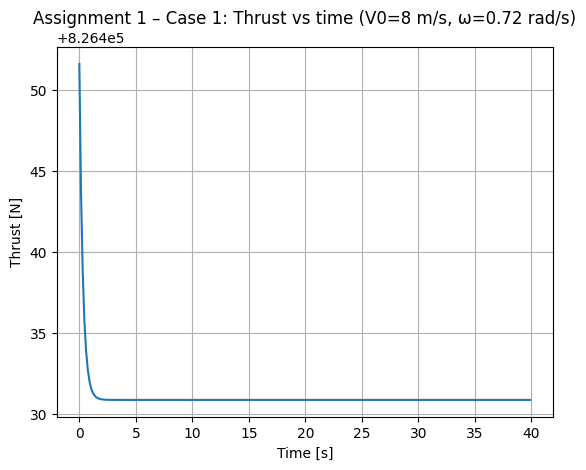

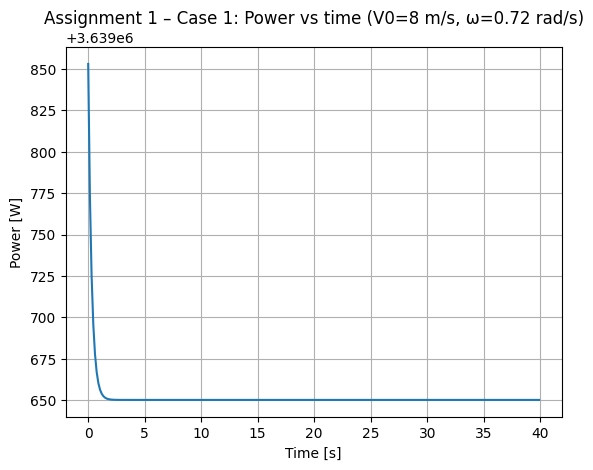

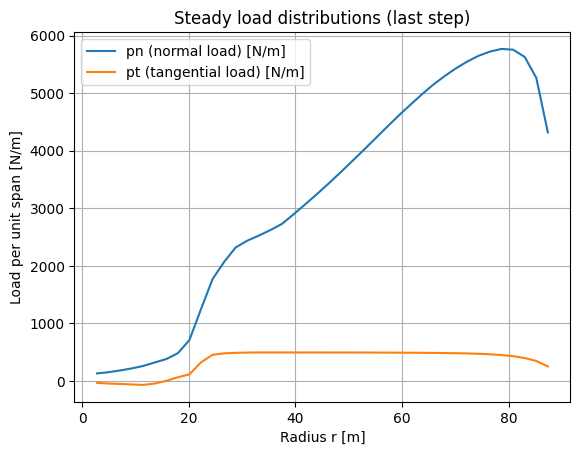

In [67]:
t = np.array(rec.t)
Thrust = np.array(rec.thrust)
Power = np.array(rec.power)

plt.figure()
plt.plot(t, Thrust)
plt.xlabel("Time [s]")
plt.ylabel("Thrust [N]")
plt.title("Assignment 1 – Case 1: Thrust vs time (V0=8 m/s, ω=0.72 rad/s)")
plt.grid(True)

plt.figure()
plt.plot(t, Power)
plt.xlabel("Time [s]")
plt.ylabel("Power [W]")
plt.title("Assignment 1 – Case 1: Power vs time (V0=8 m/s, ω=0.72 rad/s)")
plt.grid(True)

plt.figure()
plt.plot(r_sec, state.pn, label="pn (normal load) [N/m]")
plt.plot(r_sec, state.pt, label="pt (tangential load) [N/m]")
plt.xlabel("Radius r [m]")
plt.ylabel("Load per unit span [N/m]")
plt.title("Steady load distributions (last step)")
plt.grid(True)
plt.legend()

plt.show()


### Runner - A1, Case 2
- Wind shear v = 0.2
- Assumed hub height of 119 m
- $V(z) = V_{\text{hub}} \left(\frac{z}{H}\right)^{\nu}$

In [68]:
def run_case2_shear():
    cfg = ModelConfig(
        rho=rho, B=B, dt=dt,
        use_prandtl=True, min_F=0.05,
        use_glauert=True,
        relax=0.35, max_iter=80, tol=1e-4
    )

    # Case 2 settings
    cfg.wind_model = "shear"
    cfg.H = 119.0
    cfg.shear_exp = 0.2

    op = OperatingPoint(V0_hub=8.0, omega=0.72, theta_pitch_deg=0.0)

    # state for each blade (so we can plot thrust per blade)
    states = [init_state(op, r_sec) for _ in range(3)]

    rec = run_simulation(cfg, states, r_sec, c_sec, beta_sec, tc_sec, dr_sec, R_global, T_end=T_end)
    return cfg, states, rec


### Run loop - 3 blades, Case 2

In [69]:
def run_simulation(cfg: ModelConfig, states, r_sec, c_sec, beta_sec, tc_sec, dr_sec, R, T_end):
    """
    Case 2: run 3 blades so we can plot thrust per blade and total thrust.
    """
    rec = {
        "t": [],
        "T1": [],
        "T2": [],
        "T3": [],
        "Ttot": [],
        "P": []
    }

    n_steps = int(np.floor(T_end / cfg.dt)) + 1

    for k in range(n_steps):
        t = k * cfg.dt
        rec["t"].append(t)

        # azimuth for blade 1,2,3 (120 deg shift)
        theta1 = cfg.omega_for_azimuth * t  if hasattr(cfg, "omega_for_azimuth") else states[0].op.omega * t
        thetas = [theta1, theta1 + 2*np.pi/3, theta1 + 4*np.pi/3]

        T_blades = []
        P_total = 0.0

        for b in range(3):
            st = states[b]
            st.t = t

            # wind step should use azimuth for shear (see wind_step update below)
            wind_step(cfg, st, r_sec, theta=thetas[b])

            # aero
            aero_step(cfg, st, r_sec, c_sec, beta_sec, tc_sec, dr_sec, R)

            T_blades.append(st.thrust)
            P_total += st.power

        T1, T2, T3 = T_blades
        rec["T1"].append(T1)
        rec["T2"].append(T2)
        rec["T3"].append(T3)
        rec["Ttot"].append(T1 + T2 + T3)
        rec["P"].append(P_total)

    return rec


### Plots A1, Case 2

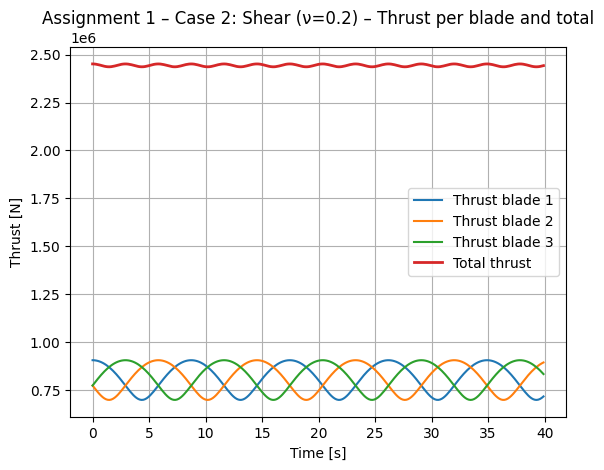

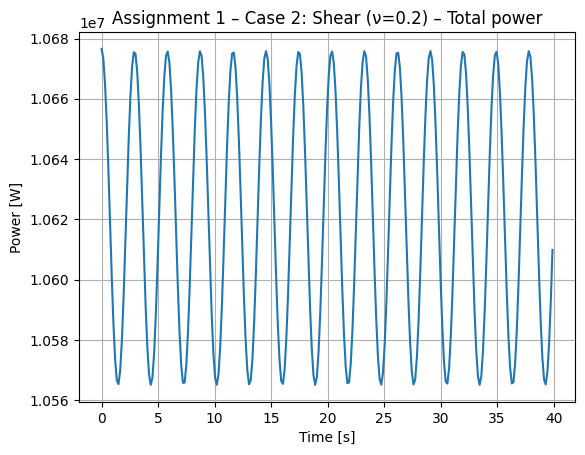

In [70]:
cfg2, states2, rec2 = run_case2_shear()

t = np.array(rec2["t"])
T1 = np.array(rec2["T1"])
T2 = np.array(rec2["T2"])
T3 = np.array(rec2["T3"])
Ttot = np.array(rec2["Ttot"])
P = np.array(rec2["P"])

plt.figure()
plt.plot(t, T1, label="Thrust blade 1")
plt.plot(t, T2, label="Thrust blade 2")
plt.plot(t, T3, label="Thrust blade 3")
plt.plot(t, Ttot, label="Total thrust", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Thrust [N]")
plt.title("Assignment 1 – Case 2: Shear (ν=0.2) – Thrust per blade and total")
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(t, P)
plt.xlabel("Time [s]")
plt.ylabel("Power [W]")
plt.title("Assignment 1 – Case 2: Shear (ν=0.2) – Total power")
plt.grid(True)

plt.show()
